In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
try:
    import empyrical as emp
except:
    emp = None
import tushare as ts
import time
import random
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq
from spider.spider_coinmarketcap import Spider_coinmarketcap

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

CONF = Config('../conf/secret.yaml').data[0]
ts_token = CONF['TUSHARE']['TOKEN']
ts.set_token(ts_token)
pro = ts.pro_api()

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
CRYPTOCURRENCY = list(CRYPTOCURRENCY.keys())
NASDAQ100 = CONF['NASDAQ100']

BENCHMARK = '399300'
ROTATION_LIST = ['399300', '000016', '000905', '399006', '000012']
ROTATION_LIST = ['399300', '000905', '399006', '000012']
ROTATION_LIST = ['399300', '000905', '399006', '000012']
# ROTATION_LIST = ['510300', '510500', '510050', '159915', '000012']

pd

<module 'pandas' from 'd:\\python36\\lib\\site-packages\\pandas\\__init__.py'>

In [2]:
%%time

### 时间设置
start_date = '2014-01-01'
end_date = '2019-05-01'
end_date = time.strftime('%Y-%m-%d')

POS = 1

### ETF Rotation System
N = 22
M = 20
K = 2

### 业务设置
START_MONEY = 100000
PROPERTY = START_MONEY
CASH = START_MONEY


Wall time: 0 ns


In [3]:
%%time

IS_DOWNLOAD_DATA = True

for symbol in ROTATION_LIST + [BENCHMARK]:
    if not IS_DOWNLOAD_DATA:
        break
        
    print(symbol)

    # 指数
    if symbol in ['399300', '000905', '000016', '399006', '000012', '000852']:
        df = ts.get_k_data(code=symbol, index=True, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        
    # ETF
    else:
        df = ts.get_k_data(code=symbol, ktype='D', autype='qfq', index=False, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        time.sleep(1)
        
#     print(datafile)
    time.sleep(1)

399300
000905
399006
000012
399300
Wall time: 8.49 s


In [4]:
%%time

stock_df_dict = {}

for symbol in ROTATION_LIST + [BENCHMARK]:
    stock_data_file = '../database/market/%s.csv' % symbol
    try:
        stock_df = pd.read_csv(stock_data_file)
    except:
        print(symbol)
        continue

    # 筛选字段
    stock_df = stock_df.loc[:, ['date', 'open', 'close']]
    
    # 特殊处理，用当天收盘价做判定和交易
#     stock_df['open'] = stock_df['close']

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ100:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    if symbol in NASDAQ100 or symbol in CRYPTOCURRENCY:
        stock_df = stock_df[::-1]
    stock_df.set_index(['date'], inplace=True)
    stock_df.index = stock_df.index.to_period('D')

    # 计算每天涨跌幅
    stock_df['o_pct_chg'] = stock_df.open.pct_change(1)
    stock_df['c_o_pct_chg'] = (stock_df.open - stock_df.close.shift(1)) / stock_df.close.shift(1)
    stock_df['N_chg'] = stock_df.open.pct_change(N)
    # 特殊处理，用昨天收盘价做判定
    stock_df['N_chg'] = (stock_df.close.shift(1) - stock_df.close.shift(N)) / stock_df.close.shift(N)
#     stock_df['N_sht'] = stock_df.open.shift(N)
#     stock_df['N_chn'] = stock_df.open.shift(N) - stock_df.open
    
    # MA均线指标
    stock_df['MA%d' % M] = stock_df['open'].rolling(M).mean()
    
    # 减少数据
    stock_df.dropna(how='any', inplace=True)
    
    stock_df_dict[symbol] = stock_df

Wall time: 94 ms


In [5]:
# 0.001534
# (97.99 - 97.63) / 97.63
# (172.37 - 172.36) / 172.36
# stock_df_dict['000012'].head()
# stock_df_dict['000012'].tail()
# stock_df_dict['000012'].iloc[0].open
# stock_df_dict['000012'].iloc[-1]

# ROTATION_LIST
# ROTATION_LIST.index('399006')
# max(ROTATION_LIST)

# for symbol in ROTATION_LIST:
# for symbol in ['399300', '510050', '000012']:
#     symbol
#     stock_df_dict[symbol].head(2)
#     stock_df_dict[symbol].loc['2007-09-04']

In [6]:
'''用基准数据来存储策略数据'''
show_df = None
show_df = stock_df_dict[BENCHMARK].copy()
show_df.loc[:, 'CASH'] = START_MONEY
show_df.loc[:, 'PROPERTY'] = START_MONEY

'用基准数据来存储策略数据'

In [7]:
%%time
# %xmode

'''ETF轮动策略，持有N天涨幅最高的标的，若涨幅全为负，则持债/货币基金。'''

PROPERTY = START_MONEY
CASH = START_MONEY
count_day = 0
yesterday = None

order_df = None
order_df = pd.DataFrame(columns=[
    'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
])

ops_df = None
ops_df = pd.DataFrame(columns=[
    'ops_date', 'ops', 'symbol', 'count', 'price', 'reason', 'profit'
])

df_start_day = stock_df_dict[BENCHMARK].head(1).index[0].strftime('%Y-%m-%d')
if df_start_day > start_date:
    run_start_day = df_start_day
else:
    run_start_day = start_date

# 时间序列
for today in pd.period_range(start=run_start_day, end=end_date, freq='D'):
    count_day += 1
    is_change = True
    
    # 每年年初计算回报率
    if today.dayofyear == 1 or today == (pd.to_datetime(end_date)).to_period(freq='D'):
        if today.dayofyear == 1:
            lastyear_firstday = pd.to_datetime('%d-01-01' % (today.year - 1))
        else:
            lastyear_firstday = pd.to_datetime('%d-01-01' % today.year)
        lastyear_firstday = lastyear_firstday.to_period(freq='D')
#         print(today, show_df.iloc[0].name, show_df[:today].iloc[-1].PROPERTY)
        if today > show_df.iloc[0].name:
            today_property = show_df[:today].iloc[-2].PROPERTY
            today_bencnmark_property = stock_df_dict[BENCHMARK][:today].iloc[-2].open
#             print(show_df[:today].iloc[-1])
        else:
            today_property = show_df.iloc[0].PROPERTY
            today_bencnmark_property = stock_df_dict[BENCHMARK].iloc[0].open
        if lastyear_firstday > show_df.iloc[0].name:
            lastyear_firstday_property = show_df[:lastyear_firstday].iloc[-1].PROPERTY
            lastyear_firstday_benchmark_property = stock_df_dict[BENCHMARK][:lastyear_firstday].iloc[-1].open
        else:
            lastyear_firstday_property = show_df.iloc[0].PROPERTY
            lastyear_firstday_benchmark_property = stock_df_dict[BENCHMARK].iloc[0].open
#         lastyear_return = round((today_property - lastyear_firstday_property) / lastyear_firstday_property, 4)
        lastyear_return = '%.3f' % ((today_property - lastyear_firstday_property) / lastyear_firstday_property)
        lastyear_benchmark_return = '%.3f' % (
            (today_bencnmark_property - lastyear_firstday_benchmark_property) / lastyear_firstday_benchmark_property
        )
        print(lastyear_firstday, today, '\t|', 
              int(lastyear_firstday_benchmark_property), int(today_bencnmark_property), lastyear_benchmark_return, '\t|', 
              int(lastyear_firstday_property), int(today_property), lastyear_return)
        
    
    if yesterday is None:
        yesterday = today
        continue

    # 日期不在基准交易日，则不交易
    if today not in stock_df_dict[BENCHMARK].index:
        continue
    
#     benchmark_today_market = stock_df_dict[BENCHMARK].loc[today]
    
    # 计算标的今天的N天涨跌幅，找到买入目标
#     N_chg_list = []
#     for symbol in ROTATION_LIST:
#         # 部分标的早期不存在
#         if today not in stock_df_dict[symbol].index:
#             N_chg_list.append(-999)
#         elif symbol == '000012':
#             N_chg_list.append(-999)
#         else:
#             today_market = stock_df_dict[symbol].loc[today]
#             N_chg_list.append(today_market.N_chg)
#     max_N_chg = max(N_chg_list)
#     target_symbol = ROTATION_LIST[N_chg_list.index(max_N_chg)]
#     if max_N_chg < 0:
#         target_symbol = '000012'
        
    
    N_chg_list = []
    for symbol in ROTATION_LIST:
        # 部分标的早期不存在
        if today not in stock_df_dict[symbol].index:
            N_chg_list.append(-999)
        else:
            today_market = stock_df_dict[symbol].loc[today]
            N_chg_list.append(today_market.N_chg)
    max_N_chg = max(N_chg_list)
    target_symbol = ROTATION_LIST[N_chg_list.index(max_N_chg)]
    
    
#     # 计算标的今天的N天涨跌幅，找到买入目标
#     N_chg_list = []
#     for symbol in ROTATION_LIST:
#         # 部分标的早期不存在
#         if today not in stock_df_dict[symbol].index:
#             N_chg_list.append(-999)
#         elif symbol == '000012':
#             N_chg_list.append(-999)
#         else:
#             today_market = stock_df_dict[symbol].loc[today]
#             N_chg_list.append(today_market.N_chg)
#     max_N_chg = max(N_chg_list)
#     target_symbol = ROTATION_LIST[N_chg_list.index(max_N_chg)]
#     today_market = stock_df_dict[target_symbol].loc[today]
#     if today_market.open < today_market['MA%d' % M]:
#         target_symbol = '000012'
    
    
    # 判断当前持有标的，和买入目标，是否相同，相同则今天不交易
    cur_order = None
    if len(order_df[(order_df['buy_count'] > 0) & (order_df['sell_price'] == 0)]) != 0:
        cur_order = order_df[(order_df['buy_count'] > 0) & (order_df['sell_price'] == 0)].iloc[-1]
        holding_symbol = cur_order.symbol
    else:
        holding_symbol = ''
        is_change = True
    if target_symbol == holding_symbol:
        is_change = False
    if cur_order is not None and today - cur_order.buy_date < K:
        is_change = False
    if holding_symbol != '' and today not in stock_df_dict[holding_symbol].index:
        is_change = False
    if today not in stock_df_dict[target_symbol].index:
        is_change = False
    
    # 当前持有标的和买入目标不相同，或者今天是首日空仓，则今天交易，换仓/全仓
    if is_change and holding_symbol != '':
        today_market = stock_df_dict[holding_symbol].loc[today]
        # 停牌了/数据出错了，今天卖不了了，完了
        if today not in stock_df_dict[holding_symbol].index:
            continue
        # 跌停板，卖不掉，其实基本不可能，因为是指数ETF轮动
        if today_market.c_o_pct_chg < -0.1 and False:
            print(today, holding_symbol, '跌停板，卖不掉')
            continue
        CASH += cur_order.buy_count * today_market.open
        idx = cur_order.name
        order_df.loc[idx, 'sell_date'] = today
        order_df.loc[idx, 'sell_price'] = today_market.open
        order_df.loc[idx, 'sell_reason'] = 'EXIT'
        order_df.loc[idx, 'profit'] = (today_market.open - cur_order.buy_price) * cur_order.buy_count
#         print(today, '退出', stock_df_dict[symbol].loc[today, 'open'], CASH)
                
        ops_df = ops_df.append(
            {
                'ops_date': today,
                'ops': 'SELL',
                'symbol': holding_symbol,
                'count': cur_order.buy_count,
                'price': today_market.open,
                'reason': cur_order.buy_reason,
                'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
            },
            ignore_index=True
        )
    
    if is_change:
        # 开始执行买入
        today_market = stock_df_dict[target_symbol].loc[today]

        # 停牌了/数据出错了，今天卖不了了，完了
        if today not in stock_df_dict[target_symbol].index:
            continue
            
        buy_price = today_market.open
        buy_count = int(CASH / buy_price)
        buy_reason = 'CHANGE'

        # 涨停板，买不进，其实基本不可能，因为是指数ETF轮动
        if today_market.c_o_pct_chg > 0.1:
            print(today, target_symbol, '涨停板，买不进')
            buy_count = 0

        if buy_count > 0:
            CASH -= buy_count * buy_price
            order_df = order_df.append(
                {
                    'buy_date': today,
                    'symbol': target_symbol,
                    'buy_count': buy_count,
                    'buy_price': today_market.open,
                    'buy_reason': buy_reason,
                    'sell_date': pd.np.nan,
                    'sell_price': 0,
                    'profit': 0,
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
            ops_df = ops_df.append(
                {
                    'ops_date': today,
                    'ops': 'BUY',
                    'symbol': target_symbol,
                    'count': buy_count,
                    'price': buy_price,
                    'reason': buy_reason,
                    'profit': 0,
                },
                ignore_index=True
            )
            
    # 每天盘点财产
    show_df.loc[today, 'CASH'] = CASH
    PROPERTY = CASH + \
        sum(
            [
                stock_df_dict[order_df.loc[idx, 'symbol']][:today].iloc[-1].open * order_df.loc[idx, 'buy_count'] \
                for idx in order_df.loc[order_df['sell_price']==0].index
            ]
        )
    show_df.loc[today, 'PROPERTY'] = PROPERTY

    
# 最后一天，清仓
order_arr = order_df.to_records(index=False)
for idx in order_df[order_df['sell_price'] == 0].index:
    cur_order = order_df.loc[idx]
    symbol = cur_order['symbol']
    today_market = stock_df_dict[symbol][:today].iloc[-1]
    CASH += cur_order.buy_count * today_market.open
    order_df.loc[idx, 'sell_date'] = today
    order_df.loc[idx, 'sell_price'] = today_market.open
    order_df.loc[idx, 'sell_reason'] = 'EXIT'
    order_df.loc[idx, 'profit'] = \
        (today_market.open - cur_order.buy_price) * cur_order.buy_count
    ops_df = ops_df.append(
        {
            'ops_date': today,
            'ops': 'SELL',
            'symbol': symbol,
            'count': cur_order.buy_count,
            'price': today_market.open,
            'reason': cur_order.buy_reason,
            'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
        },
        ignore_index=True
    )


print('START_MONEY', START_MONEY)
print('CASH', CASH)
print('PROPERTY', PROPERTY)

s_p = stock_df_dict[BENCHMARK][start_date:].iloc[0].open
e_p = stock_df_dict[BENCHMARK][:end_date].iloc[-1].open
print('BENCHMARK', s_p, e_p, e_p / s_p)

show_df['PROPERTY_ER'] = show_df['PROPERTY']

2013-01-01 2014-01-01 	| 2485 2313 -0.069 	| 100000 100000 0.000
2014-01-01 2015-01-01 	| 2289 3450 0.508 	| 100000 173532 0.735
2015-01-01 2016-01-01 	| 3462 3762 0.087 	| 174111 372664 1.140
2016-01-01 2017-01-01 	| 3760 3297 -0.123 	| 372465 320107 -0.141
2017-01-01 2018-01-01 	| 3302 3993 0.209 	| 320448 363905 0.136
2018-01-01 2019-01-01 	| 4022 3012 -0.251 	| 366117 338282 -0.076
2019-01-01 2019-05-26 	| 2994 3629 0.212 	| 338421 416938 0.232
START_MONEY 100000
CASH 417034.81
PROPERTY 417034.81
BENCHMARK 2323.43 3584.9 1.5429343685843775
Wall time: 5.97 s


In [8]:
order_df
# ops_df

,buy_date,symbol,buy_count,buy_price,buy_reason,sell_date,sell_price,sell_reason,profit,cash,property
0,2014-01-02,399006,76,1302.30,CHANGE,2014-02-14,1484.56,EXIT,13851.8,1025.20,100000
1,2014-02-14,000905,28,4063.79,CHANGE,2014-03-11,3848.17,EXIT,-6037.36,65.64,117857
2,2014-03-11,000012,769,140.08,CHANGE,2014-03-27,140.29,EXIT,161.49,92.88,111548
3,2014-03-27,000905,27,3994.82,CHANGE,2014-03-31,3865,EXIT,-3505.14,115.75,107976
4,2014-03-31,000012,744,140.38,CHANGE,2014-04-08,140.49,EXIT,81.84,28.03,106366
5,2014-04-08,399300,47,2179.92,CHANGE,2014-04-28,2165.77,EXIT,-665.05,2096.35,104627
6,2014-04-28,000012,738,140.76,CHANGE,2014-04-30,140.75,EXIT,-7.38,6.66,105299
7,2014-04-30,399300,48,2158.76,CHANGE,2014-05-06,2151.39,EXIT,-353.76,259.68,103873
8,2014-05-06,000012,734,140.89,CHANGE,2014-05-29,141.45,EXIT,411.04,113.14,103584
9,2014-05-29,399006,77,1338.30,CHANGE,2014-07-07,1411.99,EXIT,5674.13,888.34,103923


In [9]:
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
algo = df['PROPERTY'].pct_change()
benchmark = df.open.pct_change()

DAYS_ALL = len(df)
DAYS_NOFULLHOLD = len(df[df['CASH'] > (df['PROPERTY'] / POS)])

output_str = ''

df = order_df.copy()
df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
df = df.loc[:, ['symbol', 'pro_pct']]
df = df.groupby(by='symbol').sum()
buy_stock_count = len(df)

score_sr = pd.Series({
    'START': start_date,
    'END': end_date,
    'POS': POS,
    'N': N,
    'M': M,
    'K': K,
    'ORDER': len(order_df),
    'STOCK': buy_stock_count,
    'RETURN_ALGO': emp.cum_returns(algo)[-1],
    'RETURN_BENC': emp.cum_returns(benchmark)[-1],
    'MAXDROPDOWN_ALGO': emp.max_drawdown(algo),
    'MAXDROPDOWN_BENC': emp.max_drawdown(benchmark),
    'WINRATE_ORDER': len(order_df[order_df.profit > 0]) / len(order_df[order_df.profit != 0]),
    'WINRATE_YEARLY': 0,
    'ANNUAL_RETURN': emp.annual_return(algo),
    'ANNUAL_VOLATILITY': emp.annual_volatility(algo, period='daily'),
    'CALMAR_RATIO': emp.calmar_ratio(algo),
    'SHARPE_RATIO': emp.sharpe_ratio(returns=algo),
    'ALPHA': emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00),
    'BETA': emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00),
    'DAYS_ALL': DAYS_ALL,
    'DAYS_NOFULLHOLD': DAYS_NOFULLHOLD,
    'RET_PER_YEAR': output_str,
})

YEAR_COUNT = 0
ALGO_WIN_YEAR_COUNT = 0
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
for y in range(int(start_date.split('-')[0]), int(end_date.split('-')[0]) + 1, 1):
    y_df = df.loc['%d-01-01' % y:'%d-01-01' % (y + 1)]
    # info('y = %d' % y)
    if len(y_df) == 0:
        continue
    y_algo = y_df['PROPERTY'].pct_change()
    y_benchmark = y_df.open.pct_change()
    score_sr['RETURN_ALGO_%d' % y] = emp.cum_returns(y_algo)[-1]
    score_sr['RETURN_BENC_%d' % y] = emp.cum_returns(y_benchmark)[-1]
    YEAR_COUNT += 1
    if score_sr['RETURN_ALGO_%d' % y] > score_sr['RETURN_BENC_%d' % y]:
        ALGO_WIN_YEAR_COUNT += 1

score_sr['WINRATE_YEARLY'] = ALGO_WIN_YEAR_COUNT / YEAR_COUNT

score_sr

START                2014-01-01
END                  2019-05-26
POS                           1
N                            22
M                            20
K                             2
ORDER                       138
STOCK                         4
RETURN_ALGO             3.17035
RETURN_BENC            0.542934
MAXDROPDOWN_ALGO      -0.246799
MAXDROPDOWN_BENC      -0.469167
WINRATE_ORDER          0.664234
WINRATE_YEARLY         0.666667
ANNUAL_RETURN          0.315309
ANNUAL_VOLATILITY      0.242392
CALMAR_RATIO            1.27759
SHARPE_RATIO            1.25408
ALPHA                  0.238035
BETA                   0.564075
DAYS_ALL                   1313
DAYS_NOFULLHOLD               0
RET_PER_YEAR                   
RETURN_ALGO_2014       0.741115
RETURN_BENC_2014       0.490206
RETURN_ALGO_2015        1.07737
RETURN_BENC_2015      0.0546285
RETURN_ALGO_2016      -0.131567
RETURN_BENC_2016      -0.113601
RETURN_ALGO_2017       0.141373
RETURN_BENC_2017       0.213923
RETURN_A

In [10]:
'''计算标的持有、收益等'''

df = order_df.copy()
df.drop(columns=['sell_reason', 'buy_reason'], inplace=True)
# df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
df['pro_pct'] = df.sell_price / df.buy_price
# df
df.sort_values(by='pro_pct', ascending=False).head(5)
df.sort_values(by='pro_pct', ascending=False).tail(5)

# df = df.astype(dtype={'sell_date': 'datetime64[ns]', 'buy_date': 'datetime64[ns]', 'cash':'int'})
df = df.astype(dtype={'cash': 'int', 'profit': 'int'})

df['h_days'] = (df.sell_date - df.buy_date)
df['h_days'] = df['h_days'].apply(lambda x: 1 if x == 0 else x)

df['per_d'] = df.pro_pct / df.h_days * 365
# df['per_d'] = df.apply(lambda x: x.pro_pct / x.h_days)

# df.sort_values(by='pro_pct', ascending=False)
# df.sort_values(by='per_d', ascending=False)

df = df.loc[:, ['symbol', 'pro_pct']]
# df = df.groupby(by='symbol').sum()
df = df.groupby(by='symbol').prod()
df.sort_values(by='pro_pct', ascending=False).head(5)
# df.sort_values(by='pro_pct', ascending=False).tail(5)
# len(df)
df['pro_pct'].prod()

'计算标的持有、收益等'

,buy_date,symbol,buy_count,buy_price,sell_date,sell_price,profit,cash,property,pro_pct
26,2015-04-30,399006,88,2825.16,2015-06-08,3862.8,91312.3,1625.49,246833,1.36729
19,2015-01-22,399006,97,1723.24,2015-03-31,2294.32,55394.8,757.40,167866,1.3314
17,2014-11-05,399300,50,2516.87,2015-01-20,3336.79,40996,992.03,127427,1.32577
34,2015-10-12,399006,140,2233.60,2015-12-09,2677.59,62158.6,931.56,313429,1.19878
134,2019-02-19,399006,260,1419.04,2019-03-25,1662.76,63367.2,909.21,360412,1.17175


,buy_date,symbol,buy_count,buy_price,sell_date,sell_price,profit,cash,property,pro_pct
127,2018-11-20,000905,74,4629.13,2018-11-27,4393.29,-17452.2,900.49,347131,0.949053
1,2014-02-14,000905,28,4063.79,2014-03-11,3848.17,-6037.36,65.64,117857,0.946941
136,2019-04-11,399300,112,4083.46,2019-05-07,3702.27,-42693.3,1727.71,457000,0.90665
38,2016-01-04,399006,136,2706.27,2016-01-06,2433.36,-37115.8,943.83,372466,0.899156
27,2015-06-08,000905,30,11157.18,2015-06-26,9571.55,-47568.9,6836.49,353136,0.857883


,pro_pct
symbol,
399006,3.075876
399300,1.406504
000012,1.070051
000905,0.906851


4.198078000624473

Index(['open', 'close', 'o_pct_chg', 'c_o_pct_chg', 'N_chg', 'MA20', 'CASH',
       'PROPERTY_ER'],
      dtype='object')

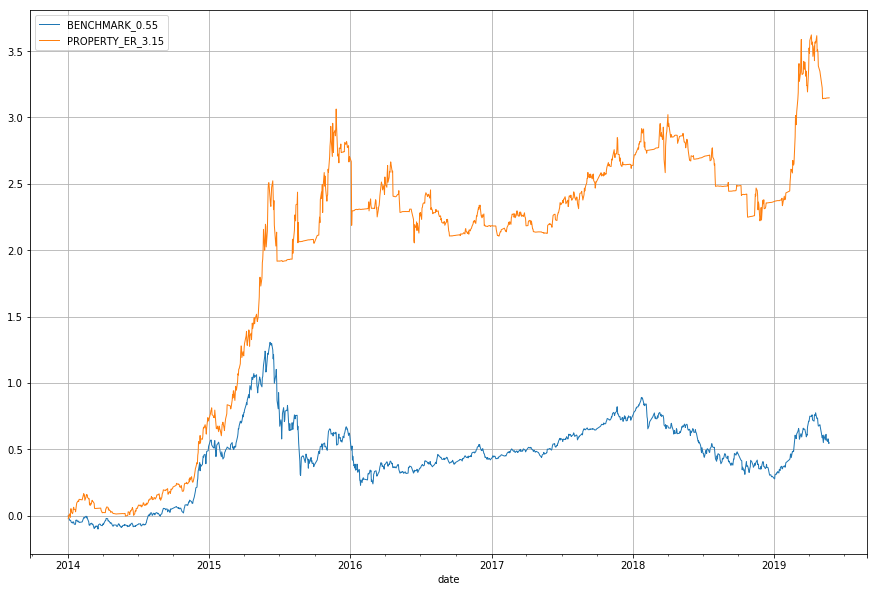

In [11]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# df = show_df.fillna(START_MONEY).copy()
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
df.drop(columns=['PROPERTY'], inplace=True)
df.columns
df = df.dropna(how='any', inplace=False)

df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
ax = df.plot(kind='line', y='close', label='BENCHMARK_%.2f' % df.iloc[-1]['close'], linewidth=1, grid=True)
for col in sorted(df.columns):
    if 'PROPERTY' in col:
        df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
        ax = df.plot(kind='line', y=col, secondary_y=False, label='%s_%.2f' % (col, df.iloc[-1][col]), linewidth=1, grid=True, ax=ax)

# display_charts(df, kind='line', figsize=(900, 600), logy=False)

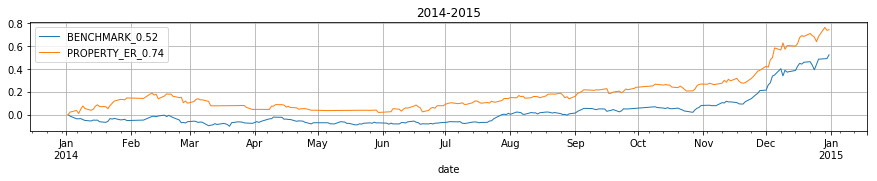

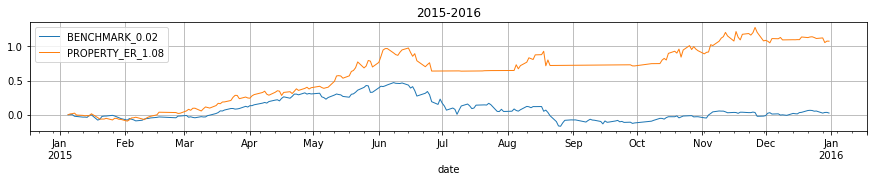

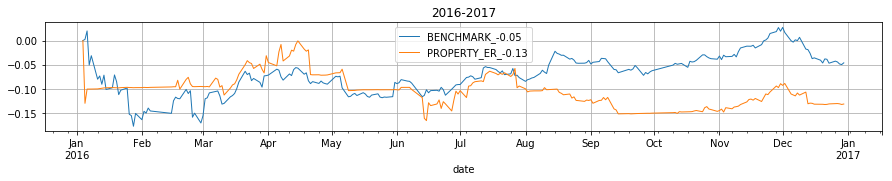

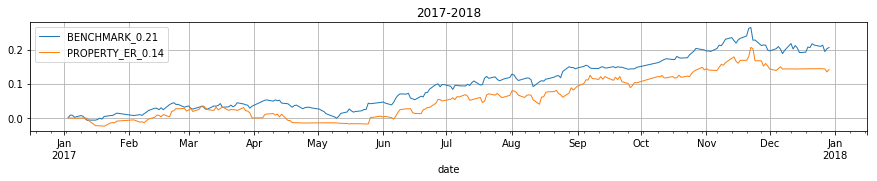

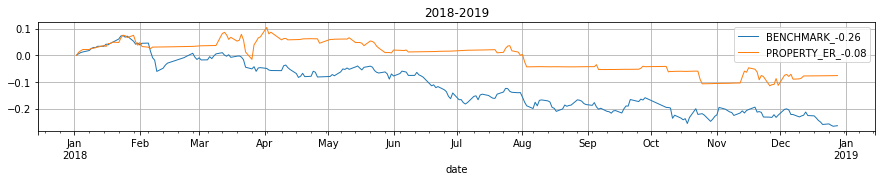

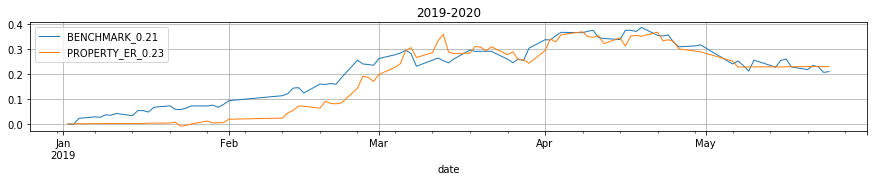

In [12]:
plt.rcParams['figure.figsize'] = [15, 2]

for y in range(int(start_date.split('-')[0]), int(end_date.split('-')[0]) + 1, 1):
    df = show_df.dropna(how='any', inplace=False).copy()
    df = df.loc['%d-01-01' % y:'%d-01-01' % (y + 1)]
    df.drop(columns=['PROPERTY'], inplace=True)
    df = df.dropna(how='any', inplace=False)
    df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
    ax = None
    ax = df.plot(kind='line', y='close', title='%d-%d' % (y, y + 1), label='BENCHMARK_%.2f' % df.iloc[-1]['close'], linewidth=1, grid=True)
    for col in sorted(df.columns):
        if 'PROPERTY' in col:
            df[col] = (df[col] - df.iloc[0][col]) / df.iloc[0][col]
            ax = df.plot(kind='line', y=col, secondary_y=False, label='%s_%.2f' % (col, df.iloc[-1][col]), linewidth=1, grid=True, ax=ax)

In [13]:
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
df.drop(columns=['PROPERTY'], inplace=True)
df.columns

show_columns = ['close']
df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
df['ER_pct_chg'] = df.PROPERTY_ER.pct_change(1)
for col in sorted(df.columns):
    if 'PROPERTY' in col:
        df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
        show_columns.append(col)

# show_columns = ['o_pct_chg', 'ER_pct_chg']
df = df.loc[:, show_columns]
# df = df.iloc[-100:]
df.reset_index(drop=False, inplace=True)
df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
df.set_index(keys=['date'], inplace=True)

display_charts(df, chart_type='stock', kind='line', figsize=(900, 600), logy=False)

Index(['open', 'close', 'o_pct_chg', 'c_o_pct_chg', 'N_chg', 'MA20', 'CASH',
       'PROPERTY_ER'],
      dtype='object')